In [143]:
import pandas as pd 
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [144]:
df = pd.read_csv("../data/clean/df_after_EDA.csv")
df.drop(['Unnamed: 0'],inplace=True,axis=1)

In [145]:
df.drop(['patient_nbr'],inplace=True,axis=1)

In [146]:
df_cat = df.select_dtypes('object')
df_num = df.select_dtypes('number')


In [147]:
df

,gender,age,weight,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,insulin,change,diabetesMed,readmitted
0,female,[70-80),[75-100),10,65,1,28,1,1,3,...,no,steady,no,no,no,no,steady,ch,yes,<30
1,male,[80-90),[50-75),6,73,0,16,0,0,0,...,no,no,no,no,no,no,steady,no,yes,no
2,male,[60-70),[100-125),2,58,3,12,0,0,0,...,no,no,no,steady,no,no,no,no,yes,>30
3,male,[40-50),[75-100),3,33,0,7,4,3,6,...,no,no,no,steady,no,no,no,no,yes,>30
4,male,[50-60),[100-125),2,5,4,11,0,0,0,...,no,no,steady,no,no,no,no,no,yes,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,male,[80-90),[50-75),3,82,0,19,0,0,0,...,no,no,no,no,no,no,no,no,no,no
878,male,[70-80),[75-100),1,69,1,20,0,0,0,...,no,no,no,no,no,no,steady,no,yes,no
879,male,[60-70),[100-125),3,48,0,11,0,0,1,...,no,steady,no,no,no,no,no,no,yes,no
880,female,[70-80),[50-75),13,82,1,22,7,0,0,...,no,no,down,no,no,no,no,ch,yes,no


In [148]:
#plots histplots for each cat column 

#for col in df_cat.columns:
#    sns.histplot(data=df_cat, x=col)
#    plt.show()

<Axes: >

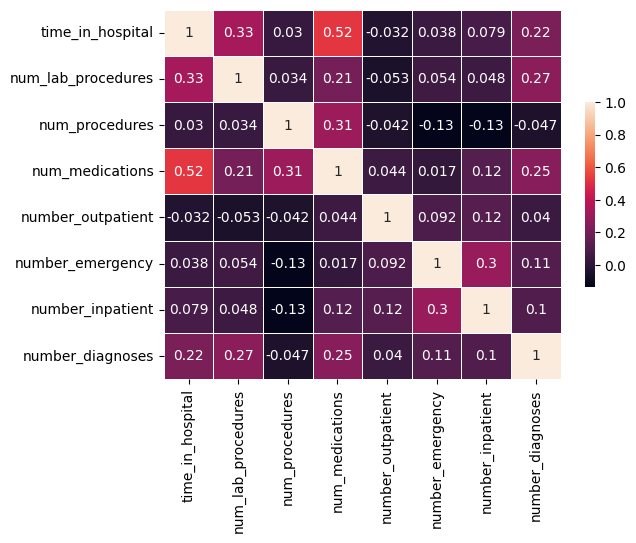

In [149]:
#checking correlations among numerical columns 

corr = df_num.corr()
sns.heatmap(corr,
            vmax=1,
            linewidth=.5,
            annot = corr,
            cbar_kws = {"shrink":.5}
           )

#seems like there are no multicollinear columns.

In [150]:
df.to_csv(path_or_buf="../data/clean/df_processed.csv")

## 1st Try with all data though distribution of target values are not equal

In [125]:
#first will change binary columns to 0s and 1

# OneHotEncoder with drop='if_binary'
encoder = OneHotEncoder(drop='if_binary', sparse_output=False)

# Identify categorical columns with 2 unique values
binary_cols = [col for col in X_train.columns if X_train[col].nunique() == 2 and X_train[col].dtype == 'object']

# Fit and transform the binary columns
X_train_encoded = X_train.copy()  # Copy the DataFrame to avoid modifying it directly
X_test_encoded = X_test.copy()  # Copy the DataFrame to avoid modifying it directly

# Encode train and test data separately
X_train_encoded[binary_cols] = encoder.fit_transform(X_train[binary_cols])
X_test_encoded[binary_cols] = encoder.transform(X_test[binary_cols])

In [126]:
#using OneHotEncoding for non-binary object columns 

non_binary_cols = [col for col in X_train_encoded.columns if X_train_encoded[col].nunique() > 2 and X_train_encoded[col].dtype == 'object']
non_binary_cols

['age',
 'weight',
 'metformin',
 'repaglinide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'insulin']

In [127]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the non-binary object columns for X_train_encoded
X_train_encoded_non_binary = encoder.fit_transform(X_train_encoded[non_binary_cols])

# Transform the non-binary object columns for X_test_encoded
X_test_encoded_non_binary = encoder.transform(X_test_encoded[non_binary_cols])

# Get the names of the new columns created by OneHotEncoder
new_columns = encoder.get_feature_names_out(input_features=non_binary_cols)

# Create DataFrames for the encoded non-binary object columns
X_train_encoded_non_binary_df = pd.DataFrame(X_train_encoded_non_binary, columns=new_columns, index=X_train_encoded.index)
X_test_encoded_non_binary_df = pd.DataFrame(X_test_encoded_non_binary, columns=new_columns, index=X_test_encoded.index)

# Concatenate the encoded non-binary object columns with the original DataFrames
X_train_encoded = pd.concat([X_train_encoded.drop(columns=non_binary_cols), X_train_encoded_non_binary_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop(columns=non_binary_cols), X_test_encoded_non_binary_df], axis=1)

In [128]:
X_test.shape

(177, 23)

In [129]:
X_test_encoded.shape

(177, 49)

In [130]:
X_test_encoded.nunique()

gender                  2
time_in_hospital       12
num_lab_procedures     65
num_procedures          7
num_medications        31
number_outpatient      11
number_emergency        6
number_inpatient        6
number_diagnoses        7
nateglinide             2
rosiglitazone           2
acarbose                2
change                  2
diabetesMed             2
age_[40-50)             2
age_[50-60)             2
age_[60-70)             2
age_[70-80)             2
age_[80-90)             2
weight_[100-125)        2
weight_[50-75)          2
weight_[75-100)         2
metformin_down          1
metformin_no            2
metformin_steady        2
metformin_up            2
repaglinide_no          2
repaglinide_steady      2
repaglinide_up          1
glimepiride_down        1
glimepiride_no          2
glimepiride_steady      2
glimepiride_up          2
glipizide_down          2
glipizide_no            2
glipizide_steady        2
glipizide_up            2
glyburide_down          1
glyburide_no

In [131]:
X_train_encoded.select_dtypes('object').nunique()

Series([], dtype: float64)

### KNN

In [132]:
normalizer = MinMaxScaler()
normalizer.fit(X_train_encoded)

MinMaxScaler()

In [133]:
X_train_norm_np = normalizer.transform(X_train_encoded)
X_test_norm_np = normalizer.transform(X_test_encoded)

In [134]:
X_train_norm_df = pd.DataFrame(X_train_norm_np, columns=X_train_encoded.columns, index=X_train_encoded.index)
X_test_norm_df  = pd.DataFrame(X_test_norm_np,  columns=X_test_encoded.columns,  index=X_test_encoded.index)

In [135]:
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train_norm_df, y_train)
# Save the model with pickle

/Users/og/Desktop/IronHackDA/7-Final_Project/SugarSync/sugarsync/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [136]:
y_pred = knn.predict(X_test_norm_df)

In [137]:
accuracy = knn.score(X_test_norm_df, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.4350282485875706


### 2

In [138]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_norm_df, y_train)

DecisionTreeClassifier(random_state=42)

In [139]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_norm_df, y_train)

/Users/og/Desktop/IronHackDA/7-Final_Project/SugarSync/sugarsync/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [140]:
dt_predictions = dt_classifier.predict(X_train_norm_df)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [177, 705]

In [141]:
rf_predictions = rf_classifier.predict(X_train_norm_df)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [177, 705]